# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


###  Problem Statement : Whether a customer will respond to an offer or not and visualise success of an offer.

In [3]:
import pandas as pd
import numpy as np
import math

import json
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from scipy import optimize
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
pd.set_option('display.max_columns', None) #display all columns
pd.set_option('display.max_rows', None) #display all rows
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import datetime

import re



In [4]:
portfolio = pd.read_json('C:/Users/yash1/Desktop/project star/portfolio.json', orient='records', lines=True)

In [5]:
portfolio.head()   #looking into data

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [75]:
#cleaning portfolio

# subdividing channels into emails,mobils,social,web,etc
#subdividing offer_types column

def clean_portfolio(portfolio):
    
   # Input:- portfolio: original dataset
   # Returns:portfolio_clean

    portfolio_clean = portfolio.copy()      # Create copy columns for the channels column

    d_chann = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack(),
                             prefix="via").sum(level=0)
    portfolio_clean = pd.concat([portfolio_clean, d_chann], axis=1, sort=False)
    portfolio_clean.drop(columns='channels', inplace=True)
    
    for index, row in portfolio_clean.iterrows():
        for offertype in ['bogo', 'informational', 'discount']:
            if offertype in portfolio_clean.loc[index, 'offer_type']:
                portfolio_clean.loc[index, offertype] = 1.0
            else:
                portfolio_clean.loc[index, offertype] = 0.0
    
    
    return portfolio_clean

In [76]:
portfolio_cleaned = clean_portfolio(portfolio)

In [77]:
pc=portfolio_cleaned
pc.head()


,reward,difficulty,duration,offer_type,id,via_email,via_mobile,via_social,via_web,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,1.0,0.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,0.0,1.0


Now we can look at the tables with more clarity

In [78]:
pc.isnull().sum() #checking for nulls for further processing

reward           0
difficulty       0
duration         0
offer_type       0
id               0
via_email        0
via_mobile       0
via_social       0
via_web          0
bogo             0
informational    0
discount         0
dtype: int64

No null values so no further processing for nulls


In [79]:
#count number of offers
portfolio.id.nunique()

10

there are 10 different offers provided by starbucks

In [80]:
of=pc.groupby(['offer_type']).mean().reset_index().sort_values(by='duration')
of.head()

,offer_type,reward,difficulty,duration,via_email,via_mobile,via_social,via_web,bogo,informational,discount
2,informational,0.0,0.00,3.5,1.0,1.00,0.50,0.50,0.0,1.0,0.0
0,bogo,7.5,7.50,6.0,1.0,1.00,0.75,0.75,1.0,0.0,0.0
1,discount,3.0,11.75,8.5,1.0,0.75,0.50,1.00,0.0,0.0,1.0


[Text(0, 0, 'informational'), Text(0, 0, 'bogo'), Text(0, 0, 'discount')]

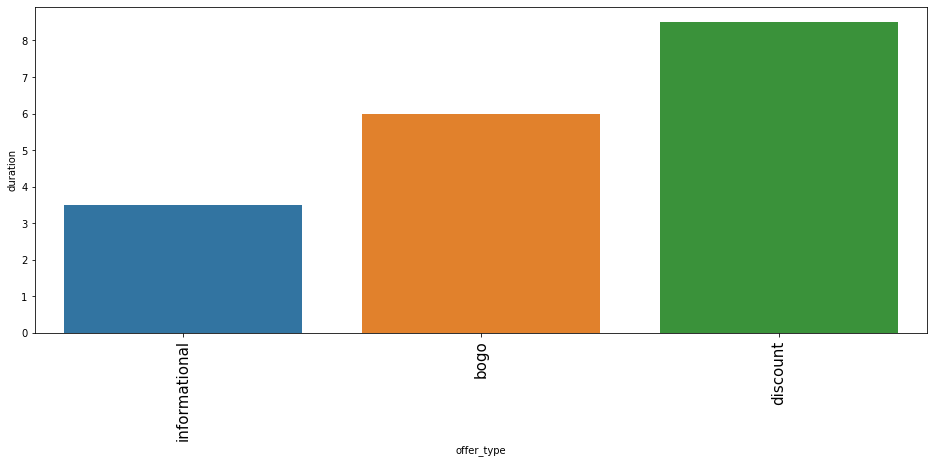

In [81]:
plt.figure(figsize=(16,6))
ax=sns.barplot(y=of['duration'], x=of['offer_type'])
ax.set_xlabel('offer_type')
ax.set_xticklabels(of['offer_type'], rotation='vertical', fontsize=15)


so here we can see that the discount offers are opened for max number of days

In [82]:
profile = pd.read_json('C:/Users/yash1/Desktop/project star/profile.json', orient='records', lines=True)


In [83]:
profile.head()


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [84]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

there are many null values to deal with , so we will deal with it first 

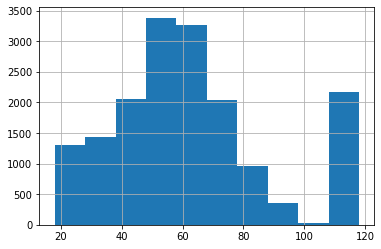

In [85]:
profile.age.hist()  #hist()  yields a histogram based on the number of times a record falls into each of the bins on which the histogram is based.


age value of 118 value does not make sense so we will deal with it out

In [86]:
profile[profile['age']==118].count() #counting the customers with age 118

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

This analysis suggests something lets see 

In [87]:
profile[profile['age']==118].head()


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


Hence  we can see here that age of 118 has gender and income values as null and NaN so we can drop them if needed

In [88]:
# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['income'].isnull()].index)

In [89]:
#cleaning profile data frame


def clean_profile(profile):
    
    
   # Input: profile: original dataset
    #Returns:profile_clean

    profile_clean = profile.copy()
    # Transform date from int to datetime
    date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    profile_clean.became_member_on = profile_clean.became_member_on.apply(date)    
    # Create column that separates customers with valid data by seperating on the basis of age =118
    profile_clean['valid'] = (profile_clean.age != 118).astype(int)
   
    # Convert gender values to numeric 0s and 1s
    profile_clean['gender'] = profile_clean['gender'].apply(lambda x: 1 if x == 'M' else 0)
    
    return profile_clean
   

In [90]:
profile_clean = clean_profile(profile)
prc=profile_clean
prc.head(100)

,gender,age,id,became_member_on,income,valid
1,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1
13,0,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,1
14,1,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,1
15,0,62,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,1
16,1,49,62cf5e10845442329191fc246e7bcea3,2014-11-13,52000.0,1
18,1,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,1


In [91]:
pc.rename(columns={'id':'offer_id'},inplace=True) 
pc.head()
#portfolio

,reward,difficulty,duration,offer_type,offer_id,via_email,via_mobile,via_social,via_web,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,1.0,0.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,0.0,1.0


In [92]:
prc.rename(columns={'id':'customer_id'}, inplace=True)

# profile: add start_year column
prc['start_year'] = prc.became_member_on.dt.year
prc["start_month"] = prc.became_member_on.dt.month
prc.head()
#profile

,gender,age,customer_id,became_member_on,income,valid,start_year,start_month
1,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,2017,7
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,2017,5
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,2018,4
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1,2018,2
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1,2017,11


For more clarity in analysis we renamed id columns in portfolio and profile dtasets to offer_id and customed_id columns and added start year and start month

In [93]:
transcript = pd.read_json('C:/Users/yash1/Desktop/project star/transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


by seeing dataframe here we need to get a seperate offer_id column from the value column and delete the value column

In [94]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

so we are not dealing with null values here

In [95]:
#cleaning transcript data
#sub dividing event column 
#getting offer_id column and amount column from value column

def clean_transcript(transcript):
    
   # Input: transcript original dataset
    # Returns:transcript_clean

    transcript_clean = transcript.copy()
    # Split event into several dummy columns
    dummy_event = pd.get_dummies(transcript_clean.event)
    transcript_clean = pd.concat([transcript_clean, dummy_event], axis=1,
                                 sort=False)
   
    # Get the offer_id data from the value column
    transcript_clean['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else None
                                    for v in transcript_clean.value]
    # Get the transaction amount data from the value column
    transcript_clean['amount'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'amount' else None
                                  for v in transcript_clean.value]
    transcript_clean.drop(columns='value', inplace=True)
    
    return transcript_clean

In [96]:
transcript_clean = clean_transcript(transcript)
tc=transcript_clean
tc.head()

,person,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [97]:
# Change the name of person column to customer_id
tc.rename(columns={'person':'customer_id'}, inplace=True)

In [98]:
tc.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [99]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
tc = tc[tc.customer_id.isin(prc.customer_id)]
tc.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [100]:
# extract transactions from transcript data
tc_df = tc[tc.event=='transaction'].copy()
tc_df.drop(columns=['offer_id', 'event'], inplace=True)
tc_df.head(20)

,customer_id,time,offer completed,offer received,offer viewed,transaction,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0,0,0,1,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,0,0,1,34.56
12659,54890f68699049c2a04d415abc25e717,0,0,0,0,1,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,0,0,0,1,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,0,0,0,1,18.97
12678,629fc02d56414d91bca360decdfa9288,0,0,0,0,1,33.90
12687,a97e6f33219c432db82acfa0d19c602d,0,0,0,0,1,18.59
12691,676506bad68e4161b9bbaffeb039626b,0,0,0,0,1,18.01
12696,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,0,0,0,1,19.11
12706,4cbe33c601a5407f8202086565c55111,0,0,0,0,1,36.19


In [101]:
# extract offer-related from transcript data
offers_df = tc[tc.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount','offer completed','offer received','offer viewed'], inplace=True)

In [102]:
offers_df.head()

,customer_id,time,transaction,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,2906b810c7d4411798c6938adc9daaa5,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0,0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,0,3f207df678b143eea3cee63160fa8bed,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


## As all the data has been cleaned now let's combine all the data to get a combined dataset for analysis

In [103]:
#combining function

def merge_datasets(portfolio_clean, profile_clean, transcript_clean):
   # Input: portfolio_clean, profile_clean,transcript_clean
    #Output:df: merged dataframe
    
    trans_prof = pd.merge(transcript_clean, profile_clean, on='customer_id',how="left")
    df = pd.merge(trans_prof, portfolio_clean, on='offer_id', how='left')
    return df

In [104]:
df = merge_datasets(pc, prc,tc)

In [105]:
df.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,gender,age,became_member_on,income,valid,start_year,start_month,reward,difficulty,duration,offer_type,via_email,via_mobile,via_social,via_web,bogo,informational,discount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,75,2017-05-09,100000.0,1,2017,5,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,68,2018-04-26,70000.0,1,2018,4,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,65,2018-02-09,53000.0,1,2018,2,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,1,58,2017-11-11,51000.0,1,2017,11,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,61,2017-09-11,57000.0,1,2017,9,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0


This is the merged dataframe

Now lets check the number of unique customers ,days the experiment was conducted and events occured

In [106]:
df['customer_id'].nunique()


14825

In [107]:
df.time.max() / 24    # time is in hours so we need to divide by 24 to get the number of days


29.75

In [108]:
df.shape


(272762, 27)

So there are 14825 valid customers  , the exp was conducted for appprox 30 days and 306534 events occured during thid period

In [109]:
df['offer_id'].nunique()

10

and 10 unique offers are there

In [110]:
df.groupby(['offer completed','offer received','offer viewed','offer_type'])['offer_type'].count()


offer completed  offer received  offer viewed  offer_type   
0                0               1             bogo             22039
                                               discount         18461
                                               informational     9360
                 1               0             bogo             26537
                                               discount         26664
                                               informational    13300
1                0               0             bogo             15258
                                               discount         17186
Name: offer_type, dtype: int64

we get a count of offer_type on the basis of events

Down we will subdivide offer_type column 

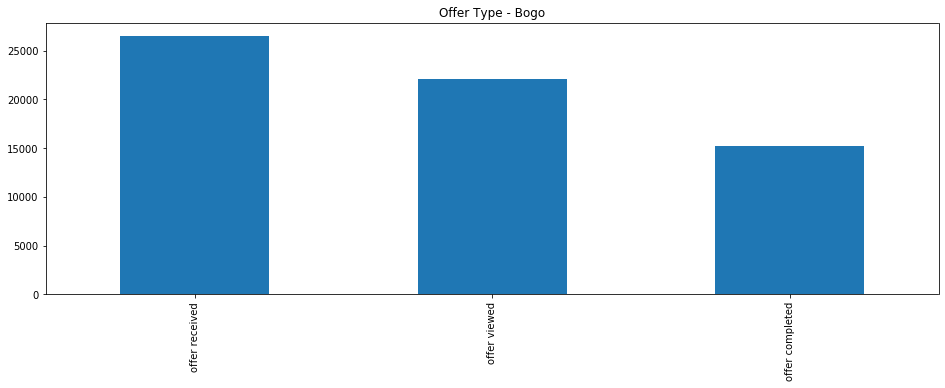

In [111]:
plt.subplot()
df[df.bogo == 1].event.value_counts().plot(kind='bar', figsize=(16,5))
plt.title('Offer Type - Bogo');



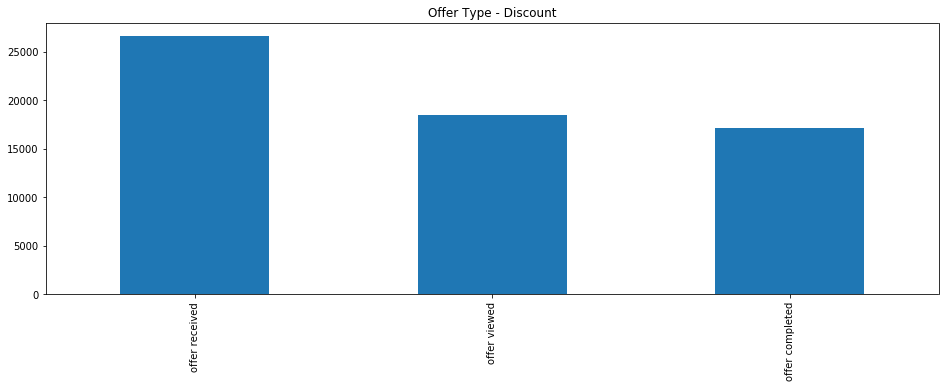

In [112]:
plt.subplot()
df[df.discount == 1].event.value_counts().plot(kind='bar', figsize=(16,5))
plt.title('Offer Type - Discount');

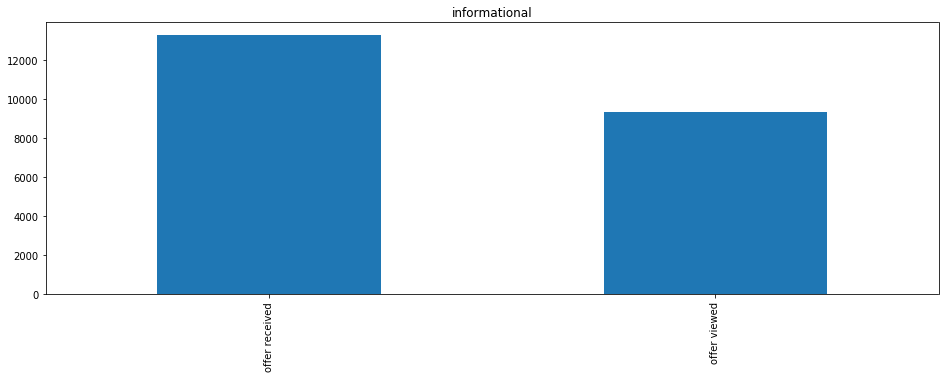

In [113]:
plt.subplot()
df[df.informational == 1].event.value_counts().plot(kind='bar', figsize=(16,5))
plt.title('informational');

In [114]:
# Change the offer ids to a simplied form
offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'a',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'b',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'c',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'd',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'e',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'f',
                'fafdcd668e3743c1bb461111dcafc2a4': 'g',
                '2906b810c7d4411798c6938adc9daaa5': 'h',
                '3f207df678b143eea3cee63160fa8bed': 'i',
                '5a8bc65990b245e5a138643cd4eb9837': 'j'}
df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)

In [115]:
df.head(20)

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,gender,age,became_member_on,income,valid,start_year,start_month,reward,difficulty,duration,offer_type,via_email,via_mobile,via_social,via_web,bogo,informational,discount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,c,NaN,0,75,2017-05-09,100000.0,1,2017,5,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,h,NaN,1,68,2018-04-26,70000.0,1,2018,4,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,0,1,0,0,d,NaN,1,65,2018-02-09,53000.0,1,2018,2,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0,1,0,0,i,NaN,1,58,2017-11-11,51000.0,1,2017,11,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0,1,0,0,e,NaN,0,61,2017-09-11,57000.0,1,2017,9,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0,1,0,0,e,NaN,0,62,2016-02-11,71000.0,1,2016,2,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0,1,0,0,a,NaN,1,64,2017-09-09,100000.0,1,2017,9,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,0,1,0,0,i,NaN,0,78,2017-06-16,71000.0,1,2017,6,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,1.0,0.0
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0,1,0,0,e,NaN,0,88,2017-05-18,53000.0,1,2017,5,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,f806632c011441378d4646567f357a21,offer received,0,0,1,0,0,g,NaN,1,42,2013-08-11,69000.0,1,2013,8,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,0.0,1.0


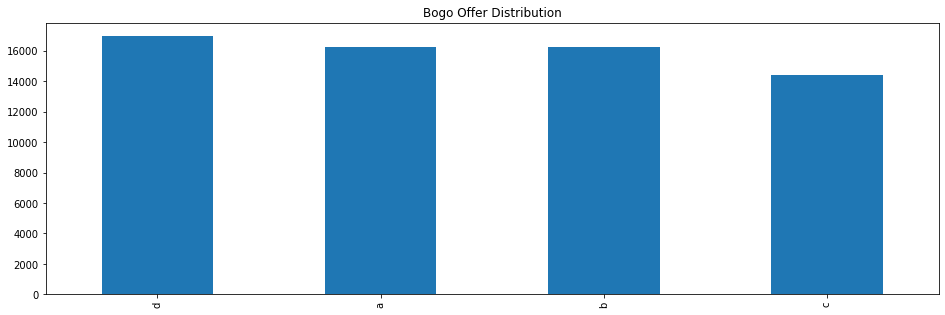

In [116]:
plt.subplot()
df[df.bogo == 1].offer_id.value_counts().plot(kind='bar', figsize=(16,5))
plt.title('Bogo Offer Distribution');





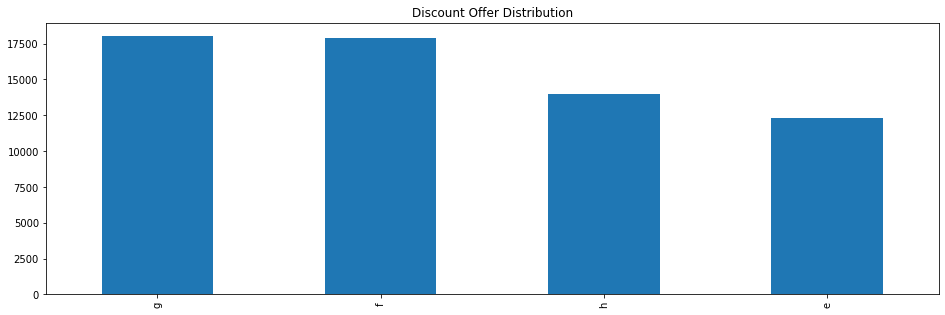

In [117]:
plt.subplot()
df[df.discount == 1].offer_id.value_counts().plot(kind='bar', figsize=(16,5))
plt.title('Discount Offer Distribution');

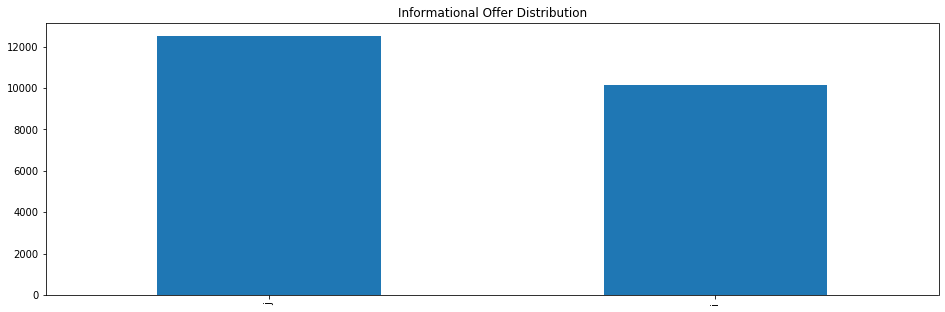

In [118]:
plt.subplot()
df[df.informational == 1].offer_id.value_counts().plot(kind='bar',  figsize=(16,5))
plt.title('Informational Offer Distribution');

In [119]:
df[df.event == 'offer received'].offer_id.value_counts()

e    6726
c    6685
a    6683
i    6657
f    6655
g    6652
j    6643
h    6631
b    6593
d    6576
Name: offer_id, dtype: int64

all offers have been recieved approx same number of times

In [120]:
df[df.event == 'offer viewed'].offer_id.value_counts()

g    6407
f    6379
b    6329
d    6310
a    5901
j    5873
c    3499
i    3487
h    3460
e    2215
Name: offer_id, dtype: int64

but there is a marginal difference in offer viewed

In [121]:
df1 = df.drop(df[df['income'].isnull()].index)  #dropping nan values income ,118 age and nan gender values
df1.head(20)

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,gender,age,became_member_on,income,valid,start_year,start_month,reward,difficulty,duration,offer_type,via_email,via_mobile,via_social,via_web,bogo,informational,discount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,c,NaN,0,75,2017-05-09,100000.0,1,2017,5,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,h,NaN,1,68,2018-04-26,70000.0,1,2018,4,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,0,1,0,0,d,NaN,1,65,2018-02-09,53000.0,1,2018,2,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0,1,0,0,i,NaN,1,58,2017-11-11,51000.0,1,2017,11,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0,1,0,0,e,NaN,0,61,2017-09-11,57000.0,1,2017,9,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0,1,0,0,e,NaN,0,62,2016-02-11,71000.0,1,2016,2,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0,1,0,0,a,NaN,1,64,2017-09-09,100000.0,1,2017,9,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,0,1,0,0,i,NaN,0,78,2017-06-16,71000.0,1,2017,6,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,1.0,0.0
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0,1,0,0,e,NaN,0,88,2017-05-18,53000.0,1,2017,5,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,f806632c011441378d4646567f357a21,offer received,0,0,1,0,0,g,NaN,1,42,2013-08-11,69000.0,1,2013,8,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [122]:
#combining  for model 
def combine_data(prc, pc, offers_df, tc_df):
    data = []
    cids = offers_df['customer_id'].unique()
    for ind in range(len(cids)):
        cid = cids[ind]
        customer = prc[prc['customer_id']==cid]
        cod = offers_df[offers_df['customer_id']==cid]
        ctd = tc_df[tc_df['customer_id']==cid]
        ofd = cod[cod['received'] == 1]
        ocd = cod[cod['completed'] == 1]
        ovd = cod[cod['viewed'] == 1]
        
        rows = []
        for i in range(ofd.shape[0]):
            offer_id = ofd.iloc[i]['offer_id']
            orw = pc.loc[pc['offer_id'] == offer_id]
            ddays = orw['duration'].values[0]
            beg_time = ofd.iloc[i]['time']
            final_time = beg_time + ddays
            bt=ocd['time'] >= beg_time
            ft=ocd['time'] <= final_time
            ocwtime = np.logical_and(bt,ft)
            oobt=ovd['time'] >= beg_time
            ooft=ovd['time'] <=final_time
            ovwtime = np.logical_and(oobt,ooft)

            
            osful = ocwtime.sum() > 0 and ovwtime.sum() > 0
            twtime = np.logical_and(
                ctd['time'] >= beg_time, ctd['time'] <= final_time)
        
            tdata = ctd[twtime]
            ttamt = tdata['amount'].sum()
            
            row = {'offer_id': offer_id,'customer_id': cid,'time': beg_time,'total_amount': ttamt,'osful': int(osful),}
                
            row.update(orw.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        data.extend(rows)
    data = pd.DataFrame(data)
    return data

In [144]:
data = combine_data(prc, pc, offers_df, tc_df)


In [145]:
data.osful.value_counts()


0    64800
1     1701
Name: osful, dtype: int64

In [146]:
data.head(20)

,offer_id,customer_id,time,total_amount,osful,reward,difficulty,duration,offer_type,via_email,via_mobile,via_social,via_web,bogo,informational,discount,gender,age,became_member_on,income,valid,start_year,start_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,5,5,7,bogo,1,1,0,1,1.0,0.0,0.0,0,75,2017-05-09,100000.0,1,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,168,0.0,0,0,0,3,informational,1,1,1,0,0.0,1.0,0.0,0,75,2017-05-09,100000.0,1,2017,5
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,408,0.0,0,10,10,7,bogo,1,1,1,0,1.0,0.0,0.0,0,75,2017-05-09,100000.0,1,2017,5
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,504,0.0,0,5,5,5,bogo,1,1,1,1,1.0,0.0,0.0,0,75,2017-05-09,100000.0,1,2017,5
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,0.0,0,2,10,7,discount,1,1,0,1,0.0,0.0,1.0,1,68,2018-04-26,70000.0,1,2018,4
5,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,336,0.0,0,0,0,4,informational,1,1,0,1,0.0,1.0,0.0,1,68,2018-04-26,70000.0,1,2018,4
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,408,0.0,0,5,5,7,bogo,1,1,0,1,1.0,0.0,0.0,1,68,2018-04-26,70000.0,1,2018,4
7,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,504,0.0,0,2,10,10,discount,1,1,1,1,0.0,0.0,1.0,1,68,2018-04-26,70000.0,1,2018,4
8,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,0,5,5,5,bogo,1,1,1,1,1.0,0.0,0.0,1,65,2018-02-09,53000.0,1,2018,2
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,168,0.0,0,5,5,7,bogo,1,1,0,1,1.0,0.0,0.0,1,65,2018-02-09,53000.0,1,2018,2


In [147]:
co=['offer_id', 'total_amount']
column_ordering = co
exco=[elem for elem in data.columns if elem not in column_ordering]
column_ordering.extend(exco)

data = data[column_ordering]

data = data.drop(columns=['time', 'customer_id', 'via_email', 'informational', 'became_member_on','offer_type'])
data.head()

,offer_id,total_amount,osful,reward,difficulty,duration,via_mobile,via_social,via_web,bogo,discount,gender,age,income,valid,start_year,start_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5,5,7,1,0,1,1.0,0.0,0,75,100000.0,1,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0,0,3,1,1,0,0.0,0.0,0,75,100000.0,1,2017,5
2,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,10,10,7,1,1,0,1.0,0.0,0,75,100000.0,1,2017,5
3,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,5,5,5,1,1,1,1.0,0.0,0,75,100000.0,1,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.0,0,2,10,7,1,0,1,0.0,1.0,1,68,70000.0,1,2018,4


# Models

In [128]:
prop = data.drop(columns=['osful'])


l = data.filter(['osful'])


X_T, X_tt, y_t, y_tt = train_test_split(prop.values, l.values, test_size=0.3, random_state=42)


oitrain = X_T[:, 0]
tatrain = X_T[:, 1]
X_T = X_T[:, 2:].astype('float64')


oitest = X_tt[:, 0]
tatest = X_tt[:, 1]
X_tt = X_tt[:, 2:].astype('float64')


y_t = y_t.ravel()
y_tt = y_tt.ravel()

In [129]:
npacc = accuracy_score(y_t, np.ones(len(y_t)))
npaf1 = f1_score(y_t, np.ones(len(y_t)))

print("Naive predictor accuracy: %.7f" % (npacc))
print("Naive predictor f1-score: %.7f" % (npaf1))

Naive predictor accuracy: 0.0256928
Naive predictor f1-score: 0.0500984


In [132]:
exp_scorer = make_scorer(fbeta_score, beta=0.5)


lr_emp_clf = LogisticRegression(random_state=42, solver='liblinear')
pen1=['l1', 'l2']
C11= [1.0, 0.1, 0.01]

grid_params = {
    'penalty':pen1 ,'C':C11}

lr_random = RandomizedSearchCV(estimator = lr_emp_clf, param_distributions = grid_params,scoring=exp_scorer, n_iter = 6, cv = 3, verbose=2,random_state=42, n_jobs = 3)


lr_random.fit(X_T, y_t)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    8.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=6, n_jobs=3,
                   param_distributions={'C': [1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False,
                   scoring=make_scor

In [134]:
rf_clf = RandomForestClassifier(random_state=42)

nest=[10, 50, 100, 150, 200, 250, 300]
n_estimators = nest

mfea=['auto', 'sqrt']
max_features = mfea

max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

msplt=[2, 5, 10]
min_samples_split = msplt

msleaf=[1, 2, 4]
min_samples_leaf = msleaf


grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

rf_random.fit(X_T, y_t)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  8.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [136]:
def evaluate_model_performance(emp_clf, X_T, y_t):
    cname = re.sub("[<>']", '', str(emp_clf.__class__))
    cname = cname.split(' ')[1]
    cname = cname.split('.')[-1]

    y_pred_rf = emp_clf.predict(X_T)

    accuracy = accuracy_score(y_t, y_pred_rf)
    f1sc = f1_score(y_t, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (cname, accuracy))
    print("%s model f1-score: %.3f" % (cname, f1sc))
    
    return accuracy, f1sc

In [137]:
evaluate_model_performance(rf_random.best_estimator_, X_T, y_t)

RandomForestClassifier model accuracy: 0.994
RandomForestClassifier model f1-score: 0.872


(0.9939634801288937, 0.8719817767653757)

In [139]:
evaluate_model_performance(rf_random.best_estimator_, X_tt, y_tt)


RandomForestClassifier model accuracy: 0.968
RandomForestClassifier model f1-score: 0.045


(0.9681218986516966, 0.04504504504504504)

# Summary




Cleaned the data from all null and duplicate values.

Removed all faulty inputs.

Saw a clear picture of offers distribution .

Modeled with the help of Random Forest Classifier and Naive Classifier Model.

## Imporvement


Some disadvantages are also there like Random forests have been observed to overfit for some datasets with noisy classification/regression tasks AND for data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data.

Additionally, better predictions may have been deducted if there were more customer metrics. For this analysis, I feel we had limited information about customer available to us — just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results.